# ImageWoof Regularization Experiments
- Dataset: [ImageNette](https://github.com/fastai/imagenette)
- Official [Tutorial](https://docs.fast.ai/tutorial.vision.html) by FastAI
- [MOOC](https://course.fast.ai/videos/)
- Documentation about image m https://docs.fast.ai/vision.models.xresnet.html
- Inofficial Tutorials/docs
  - [ImageWoof](https://kdorichev.github.io/deeplearning//Image_Classification_Imagewoof) tutorial with wrong labels
  - [Interesting Notebook](https://kshitij09.github.io/fast_impl/visualize.grad_cam/) using woof dataset




# Setup

## Environment

In [ ]:
#setup fastai notebook
!pip install -Uqq fastai #fastbook 
# import fastbook
# fastbook.setup_book()

In [ ]:
#@title imports
# from fastbook import *
from fastai.vision.all import *

from fastprogress import fastprogress
from torchvision.models import *

## Load Dataset

Different Datasets available in URLs [[source]](https://docs.fast.ai/data.external):
- __IMAGENETTE__: A smaller version of the imagenet dataset pronounced just like 'Imagenet', except with a corny inauthentic French accent.
- __IMAGENETTE_160__: The 160px version of the Imagenette dataset.
- __IMAGENETTE_320__: The 320px version of the Imagenette dataset.
- __IMAGEWOOF__: Imagewoof is a subset of 10 classes from Imagenet that aren't so easy to classify, since they're all dog breeds.
- __IMAGEWOOF_160__: 160px version of the ImageWoof dataset.
- __IMAGEWOOF_320__: 320px version of the ImageWoof dataset.

In [ ]:
# TODO: Why are we not using the 160 - Version of Imagewoof if we are going to crop it to 128 anyway?

# true for imagewoof, else imagenette
woof = True
if woof:
  path = untar_data(URLs.IMAGEWOOF_160)
else:
  path = untar_data(URLs.IMAGENETTE)

files = get_image_files(path/"train")
print("Training images: ", len(get_image_files(path/"train")),'(' ,round(len(get_image_files(path/"train"))*100/len(get_image_files(path)),2), '%)')
print("Validation images: ", len(get_image_files(path/"val")),'(' ,round(len(get_image_files(path/"val"))*100/len(get_image_files(path)),2), '%)')


Training images:  9025 ( 69.67 %)
Validation images:  3929 ( 30.33 %)


In [ ]:
#setup data

#dls = ImageDataLoaders.from_folder(path, valid='val', item_tfms=RandomResizedCrop(128, min_scale=0.35), batch_tfms=Normalize.from_stats(*imagenet_stats))
#dls.show_batch()

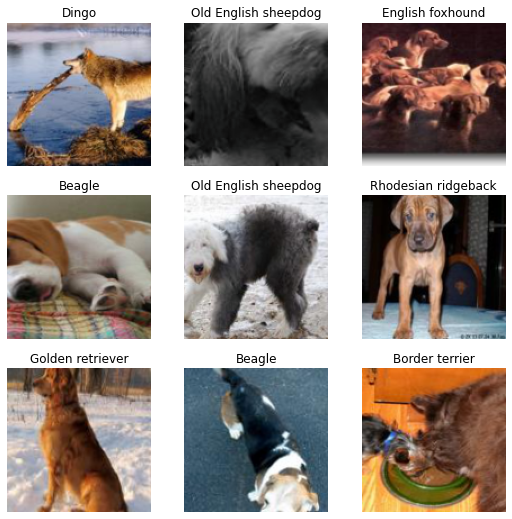

In [ ]:
#get all the images
fnames = get_image_files(path)

#create dict to show better readable labels
if woof:
  lbl_dict = dict(
    n02086240= 'Shih-Tzu',
    n02087394= 'Rhodesian ridgeback',
    n02088364= 'Beagle',
    n02089973= 'English foxhound',
    n02093754= 'Australian terrier',
    n02096294= 'Border terrier',
    n02099601= 'Golden retriever',
    n02105641= 'Old English sheepdog',
    n02111889= 'Samoyed',
    n02115641= 'Dingo'
  )
else:
  lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
  )
#function to return human readable filenames
# def label_func(fname):
#   return lbl_dict[parent_label(fname)]

#define a datablock
dblock = DataBlock(
      #set input to image and the goal to ctaegories
      blocks = (ImageBlock, CategoryBlock),
      #get names inside data block
      get_items = get_image_files,
      #label the items uin a readbale manner
      # get_y=label_func,
      get_y=Pipeline([parent_label,lbl_dict.__getitem__]),
      #split between test and trainining by folder two ages above
      splitter = GrandparentSplitter(valid_name='val'),
      #randomize the input & batch transform
      item_tfms = RandomResizedCrop(128, min_scale=0.35), 
      batch_tfms = Normalize.from_stats(*imagenet_stats)
      )

  #convert to dataloader
dls = dblock.dataloaders(path)
dls.show_batch()

## Confirm Images

In [ ]:
# fnames2 = get_image_files(path/"train/n02093754/")
# dblock = DataBlock(
#       #set input to image and the goal to ctaegories
#       blocks = (ImageBlock, CategoryBlock),
#       #get names inside data block
#       get_items = get_image_files,
#       #label the items uin a readbale manner
#       get_y=Pipeline([parent_label,lbl_dict.__getitem__]),
#       #split between test and trainining by folder two ages above
#       splitter = GrandparentSplitter(valid_name='val'),
#       #randomize the input & batch transform
#       item_tfms = RandomResizedCrop(128, min_scale=0.35), 
#       batch_tfms = Normalize.from_stats(*imagenet_stats)
#       )

#   #convert to dataloader
# dls = dblock.dataloaders(path/"train/n02087394/")
# # print(dls.vocab) # print all labels
# dls.show_batch()

# Experiments

## Base Model Test

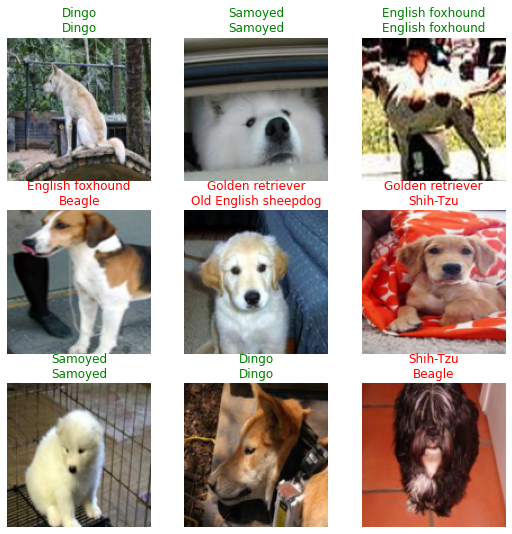

In [ ]:
#train

learn = cnn_learner(dls, resnet50, metrics=accuracy, pretrained=False)
learn.fit_one_cycle(20)
learn.show_results()

## Pooling

### MaxPool

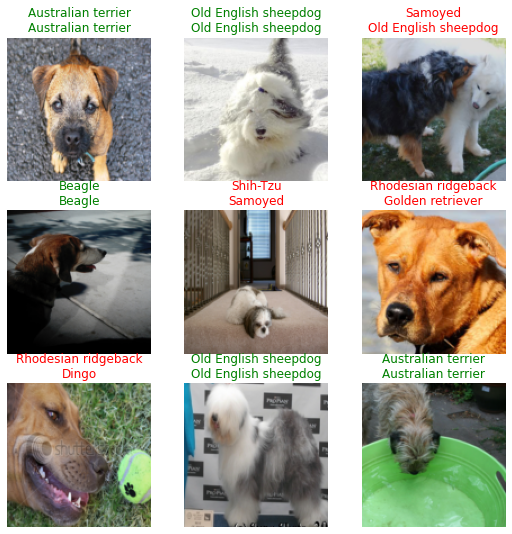

In [ ]:
  learn = Learner(dls,                      
                     #xse_resnext50
                     XResNet(SEBlock,  4, g1, n_out=10, sa=True, pool=MaxPool), 
                     opt_func=partial(ranger, mom=.95, sqr_mom=.99, eps=1e-6), 
                     
                     metrics=accuracy)
  learn.fit_one_cycle(20, 8e-3)
  learn.show_results()

### AvgPool

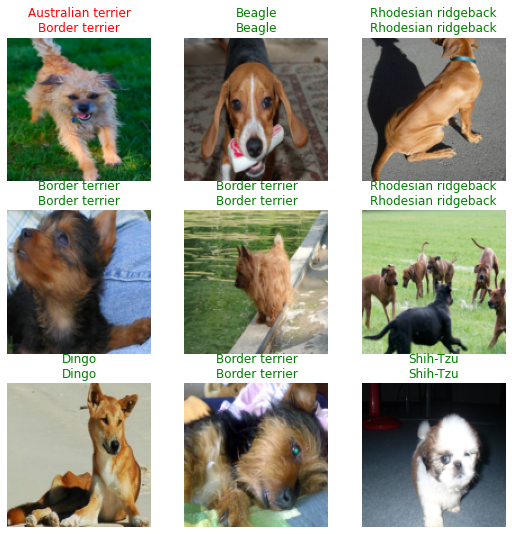

In [ ]:
  learn = Learner(dls,                      
                     #xse_resnext50
                     XResNet(SEBlock,  4, g1, n_out=10, sa=True, pool=AvgPool), 
                     opt_func=partial(ranger, mom=.95, sqr_mom=.99, eps=1e-6), 
                     
                     metrics=accuracy)
  learn.fit_one_cycle(20, 8e-3)
  learn.show_results()

### AdaptiveAvgPool

In [ ]:
# Doesnt work yet.

### MaxBlurPool
Probably need to implement this myself.
[Some](https://github.com/ayasyrev/imagenette_experiments/) [more](https://github.com/ducha-aiki/Ranger-Mish-ImageWoof-5/blob/master/mxresnet.py#L121) [Resources](https://forums.fast.ai/t/imagenette-imagewoof-leaderboards/45822/19) 

Lets Try ResNext just for fun

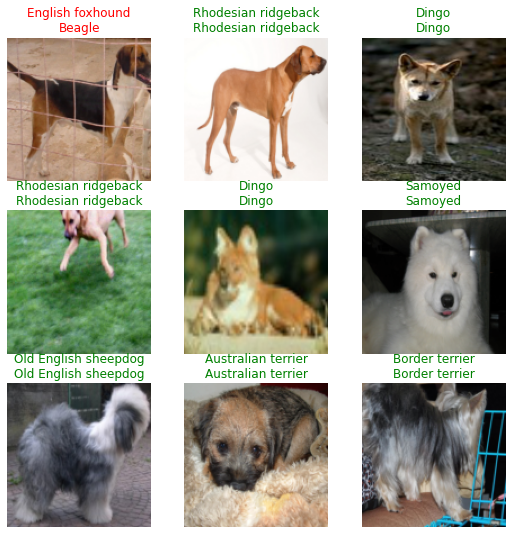

In [ ]:
# !pip install -Uqq kornia
# import kornia
# layer_new = kornia.contrib.MaxBlurPool2d(3, True)
learn = Learner(dls,                      
                    #xse_resnext50
                    XResNet(SEResNeXtBlock, 4, g1, n_out=10, sa=True, pool=MaxPool), 
                    opt_func=partial(ranger, mom=.95, sqr_mom=.99, eps=1e-6), 
                    
                    metrics=accuracy)
learn.fit_one_cycle(20, 8e-3)
learn.show_results()

In [ ]:
# has_pool_type(resnet34)
# learn.model # get the model
# print(resnet34)

# m = create_body(resnet34)


# new_md = nn.Sequential(*list(children(md))[:-5], custom_head) # assuming pooling is at layer -5, remove it and then put a custom head ontop
# learn_new = ConvLearner.from_model_data(new_md, data) # create a new learner with the new model


<function resnet34 at 0x7f08300a6048>


In [ ]:
# import kornia
# layer_new = kornia.contrib.MaxBlurPool2d(3, True)
# # from https://github.com/ducha-aiki/imagewoofv2-fastv2-maxpoolblur/blob/master/fastai2-imagenette-train-maxblurpool.ipynb



ModuleNotFoundError: ignored

## Loss functions
- L2
- L1
- [More](https://docs.fast.ai/losses.html) ? 
loss_func=torch.nn.CrossEntropyLoss

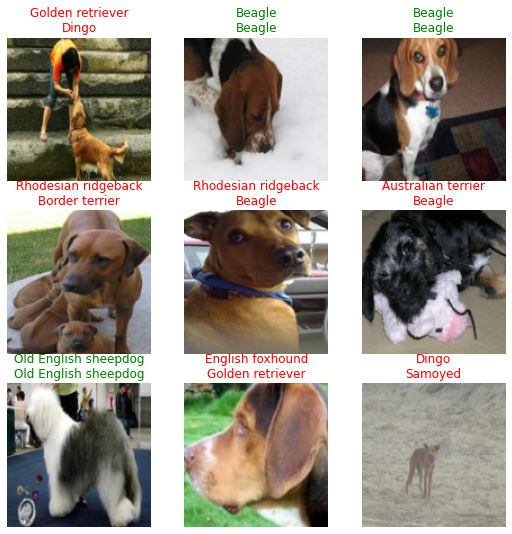

### L2 Regularization (Weight decay)
The default weight decay in fastai is 1e-2. (See Base Model for comparison)




#### No Weight Decay

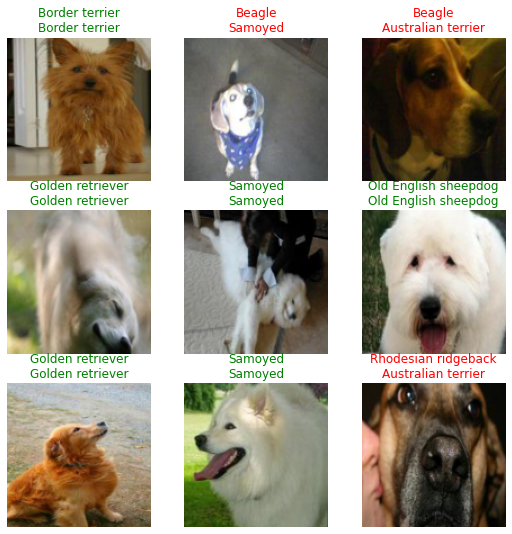

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=accuracy, pretrained=False, wd=0)
learn.fit_one_cycle(20)
learn.show_results()

#### Weight Decay: 0.05

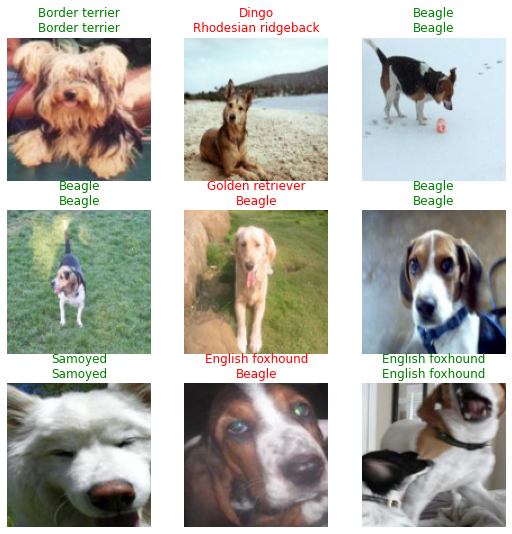

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=accuracy, pretrained=False, wd=5e-2)
learn.fit_one_cycle(20)
learn.show_results()

#### Weight Decay: 0.1

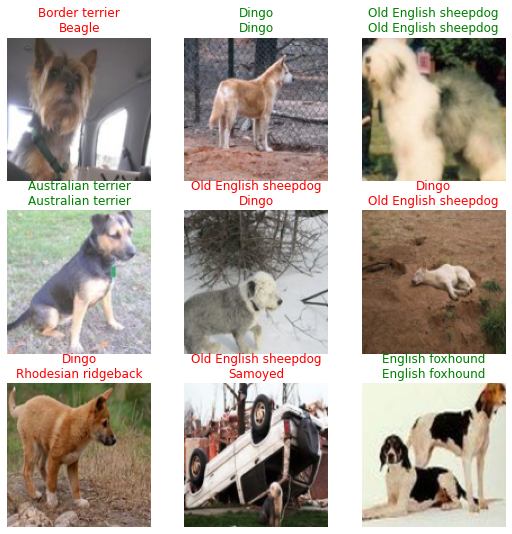

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=accuracy, pretrained=False, wd=1e-1)
learn.fit_one_cycle(20)
learn.show_results()

#### Weight Decay: 0.3

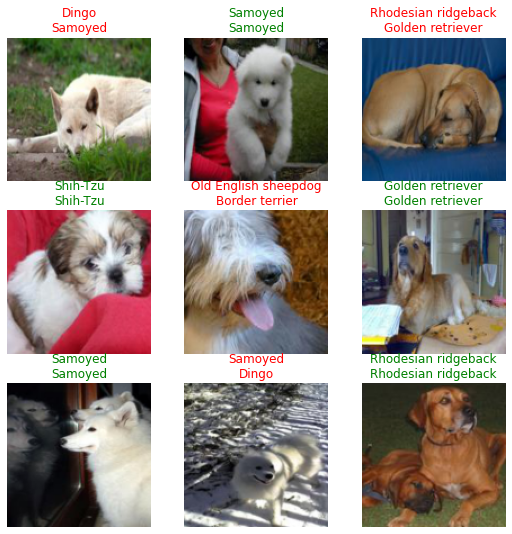

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=accuracy, pretrained=False, wd=3e-1)
learn.fit_one_cycle(20)
learn.show_results()

#### Weight Decay: 0.4


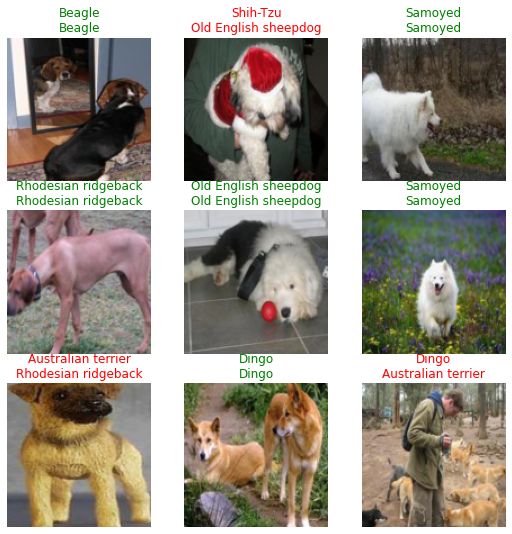

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=accuracy, pretrained=False, wd=4e-1)
learn.fit_one_cycle(20)
learn.show_results()

### L1 Regularization

In [ ]:
# w = torch.cuda.FloatTensor([1.0, 0.9, 1.1])
# learn = create_cnn(data, models.resnet18, metrics = error_rate, loss_func=torch.nn.CrossEntropyLoss(weight=w))
# learn.fit_one_cycle(1, 0.001)

# geht auch, nachdem der Learner bereits erstellt wurde: 
#  loss_func=torch.nn.CrossEntropyLoss